In [1]:
#%%
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *
import seaborn as sns

folder_path = '../experiment_data/tk_11092023'

exp_layout = {0:(0,['B','C','D']),
              10**-2:(0,['E','F','G']),
              10**-1:(1,['B','C','D']),
              10**0:(1,['E','F','G']),
              10**1:(2,['B','C','D']),
              10**2:(2,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


rfu30_to_dilution = cal.run()

In [2]:
def get_timeseries(folder_path,plate_num):
    """Takes a folder of excel files and returns a list of plates and a list of data
    Each element in the list corresponds to a plate scan.
    Specify plate num to get the data from a specific excel sheet.

    Args:
        folder_path (str): path to the folder containing the excel files
        plate_num (int): the excel sheet number corresponding to the plate

    Returns:
        list: list of plate objects
        list: list of dictionaries containing the data
    """
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [3]:
# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_raw = {}
cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,10))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key]
            # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t,background_subtracted=False)
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)
    cell_count_raw[exp_key] = cell_count_data

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

dict_t = {'time':time,
          'mean':mean_dict,
          'err':err_dict,
          'cell_count_mean':cell_count_mean,
          'cell_count_err':cell_count_err,
          'cell_count_log_err':cell_count_log_err}

# save as pickle

with open('data_11092023.pickle','wb') as f:
    pickle.dump(dict_t,f)

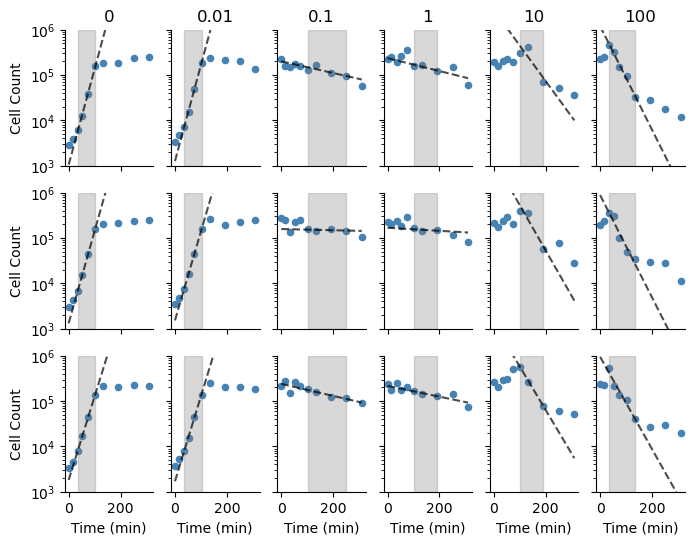

In [4]:
n_replicates = 3
n_conditions = len(cell_count_mean.keys())

fig,ax_list = plt.subplots(nrows=n_replicates,ncols=n_conditions,figsize=(8,6),sharex=True,sharey=True)

gr_dict = {}

exclude = 2

row_indx = 0

for key in cell_count_mean.keys():

    X = (time - np.min(time))/(np.max(time) - np.min(time))
    X = X[exclude:]

    Y = np.log10(cell_count_mean[key])[exclude:]
    Y = (Y - np.min(Y))/(np.max(Y) - np.min(Y))

    # ax = ax_list[i]
    # ax.plot(X,Y)

    # determine upper and lower bounds for the slope
    if Y[-1] > Y[0]:
        slope_ub = np.inf
        slope_lb = 0.01
    else:
        slope_ub = 0
        slope_lb = -np.inf

    lin_range = opt_linear_range(X,Y,1,slope_ub=slope_ub,slope_lb=slope_lb)

    slope_est = []

    for i in range(n_replicates):
        ax = ax_list[i,row_indx]
        
        X = time
        Y = cell_count_raw[key][i]

        ax.scatter(X,Y,color='steelblue',alpha=1,s=20)

        ax.axvspan(X[lin_range[0]+exclude],X[lin_range[1]-1+exclude],color='gray',alpha=0.3)

        X_reg = X[lin_range[0]+exclude:lin_range[1]+exclude]
        Y_reg = Y[lin_range[0]+exclude:lin_range[1]+exclude]

        res = stats.linregress(X_reg,np.log10(Y_reg))

        X_fit = np.linspace(np.min(time),np.max(time),100)
        Y_fit = 10**(res.slope*X_fit + res.intercept)

        ax.plot(X_fit,Y_fit,color='k',linestyle='--',alpha=0.7)

        ax.set_yscale('log')

        slope_est.append(res.slope)

    dict_t = {'mean':np.mean(slope_est),
              'err':np.std(slope_est)/np.sqrt(n_replicates)}
    gr_dict[key] = dict_t

    row_indx += 1

for ax in ax_list.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim(10**3,10**6)

for ax in ax_list[:,0]:
    ax.set_ylabel('Cell Count')

for ax in ax_list[-1,:]:
    ax.set_xlabel('Time (min)')

for key,i in enumerate(cell_count_mean.keys()):
    ax_list[0,key].set_title(str(i))

fig.savefig('../../figures/raw_data_with_fit.pdf',bbox_inches='tight')

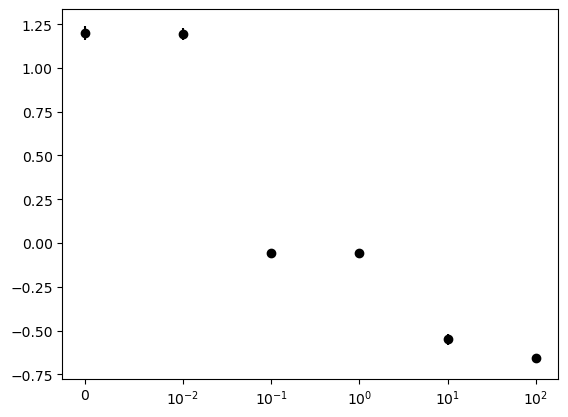

In [5]:
fig,ax = plt.subplots()

gr_vect = np.array([gr_dict[key]['mean'] for key in gr_dict.keys()])*60
err_vect = np.array([gr_dict[key]['err'] for key in gr_dict.keys()])*60

ax.errorbar(gr_dict.keys(),gr_vect,yerr=err_vect,fmt='o',color='k')

ax.set_xscale('symlog',linthresh=0.01)

In [6]:
auc_dict = {}

for key in cell_count_mean.keys():

    auc_est = []
    for i in range(n_replicates):
        y = np.log10(cell_count_raw[key][i])
        y = y/y[0]
        auc_est.append(np.trapz(time,y))
    
    dict_t = {'avg':np.mean(auc_est),'err':np.std(auc_est)/np.sqrt(len(auc_est))}
    auc_dict[key] = dict_t

# normalize for conc = 0
max_auc = auc_dict[0]['avg']
for key in auc_dict.keys():
    auc_dict[key]['avg'] = auc_dict[key]['avg']/max_auc
    auc_dict[key]['err'] = auc_dict[key]['err']/max_auc

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_38225/981305663.py:21: RuntimeWarning: invalid value encountered in double_scalars
  g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))


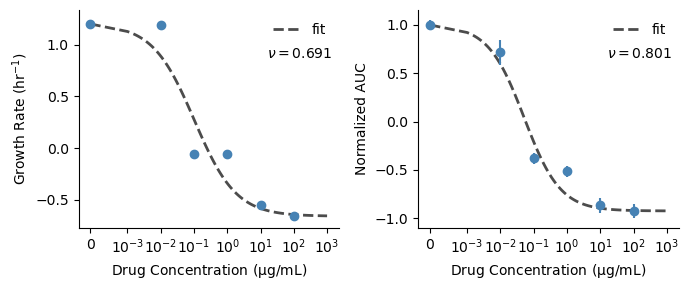

In [7]:
def pharmacodynamic_curve(c, gmax, gmin, mic, k):
    """pharmacodynamic model adapted from Foerster et al.

    Foerster, S., Unemo, M., Hathaway, L.J. et al. Time-kill curve analysis and
    pharmacodynamic modelling for in vitro evaluation of antimicrobials against Neisseria
    gonorrhoeae . BMC Microbiol 16, 216 (2016). 
    https://doi.org/10.1186/s12866-016-0838-9

    Args:
        c (float): drug concentration
        gmax (float): max growth rate
        gmin (float): min growth rate
        mic (float): estimated minimum inhibitory concentration
        k (float): hill coefficient
    """
    g = []
    for c_t in c:
        if c_t == 0:
            g.append(gmax)
        else:
            g.append(gmax - (((gmax-gmin)*(c_t/mic)**k)/((c_t/mic)**k-(gmin/gmax))))
    
    return g

fig,ax_list = plt.subplots(ncols=2,figsize=(7,3))

ax = ax_list[0]

gr_mean = np.array([gr_dict[key]['mean'] for key in gr_dict.keys()])*60
err_vect = np.array([gr_dict[key]['err'] for key in gr_dict.keys()])*60

ax.errorbar(gr_dict.keys(),gr_mean,yerr=err_vect,fmt='o',color='steelblue',alpha=1)

conc_list = np.array(list(gr_dict.keys()))

gmin = np.min(gr_mean)
gmax = np.max(gr_mean)

# p0 = [gmax_est,gmin_est,0.1,1]

p0 = [1,0.1]
popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                        conc_list,gr_mean,p0=p0,maxfev=100000)

conc_fit = np.logspace(-3,3,100)
# append 0 to the beginning of the array
conc_fit = np.insert(conc_fit,0,0)
gr_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])

gr_fit = np.array(gr_fit)

ax.plot(conc_fit,gr_fit,'--',color='black',alpha=0.7,linewidth=2,zorder=-1,label='fit')

ax.set_xscale('symlog',linthresh=0.001)

ax.legend(frameon=False)
ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
ax.set_ylabel('Growth Rate (hr$^{-1}$)')

ax.annotate('$\\nu = $' + str(round(popt[1],3)),(0.85,0.8),xycoords='axes fraction',ha='center',va='center')

# do the same for AUC

ax = ax_list[1]

auc_mean = []
for key in auc_dict.keys():
    ax.errorbar(key,auc_dict[key]['avg'],yerr=auc_dict[key]['err'],fmt='o',color='steelblue',alpha=1)
    auc_mean.append(auc_dict[key]['avg'])

auc_mean = np.array(auc_mean)
conc_list = np.array(list(auc_dict.keys()))

gmin = np.min(auc_mean)
gmax = np.max(auc_mean)

p0 = [0.1,1]
popt,pcov = curve_fit(lambda x, mic,k: pharmacodynamic_curve(x,gmax,gmin,mic,k),
                        conc_list,auc_mean,p0=p0,maxfev=100000)

conc_fit = np.logspace(-3,3,100)

# append 0 to the beginning of the array
conc_fit = np.insert(conc_fit,0,0)

# auc_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,0.1,1)
auc_fit = pharmacodynamic_curve(conc_fit,gmax,gmin,popt[0],popt[1])

ax.plot(conc_fit,auc_fit,'--',color='black',alpha=0.7,linewidth=2,zorder=-1,label='fit')

ax.set_xscale('symlog',linthresh=0.001)
ax.set_xlabel('Drug Concentration ($\mathrm{\mu}$g/mL)')
ax.set_ylabel('Normalized AUC')

ax.legend(frameon=False)

# remove right and top spines
for ax in ax_list:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

ax.annotate('$\\nu = $' + str(round(popt[1],3)),(0.85,0.8),xycoords='axes fraction',ha='center',va='center')

fig.tight_layout()

fig.savefig('../../figures/pharmacodynamic_fit.pdf',bbox_inches='tight')